<a href="https://colab.research.google.com/github/Enovak001/RaspberryRecognition/blob/main/object_recognition_faster_rcnn_openimages_v4_inception_resnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👀✨🍇🍓 This notebook is Object Detector for Raspberry detection based on Kaggle dataset (https://www.kaggle.com/datasets/metavision/accurate-raspberry-shapessegmentation) and using Object detection model trained on Open Images V4 with ImageNet pre-trained Inception Resnet V2 as image feature extractor and/or EfficientDet/D7 Object detection model.

### 1. Problem
Predicting approximate quantity of raspberries on a field during one season by implementing images of a raspberry field, detecting and making prediction of a quantity.

### 2. Task:
Using object detection model, we will try to count raspberries on the images and predict yearly quantity.

### 3. Data
We will be using Kaggle dataset: 
* Accurate raspberry shapes/segmentation -> https://www.kaggle.com/datasets/metavision/accurate-raspberry-shapessegmentation

### 4. Evaluation
**Not possible!**

We can evaluate only by checking with field owners and trust their experienced judgement.

### 5. Extras

We will be using:

1. Object detection model trained on Open Images V4 with ImageNet pre-trained Inception Resnet V2 as image feature extractor.
* https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

2. EfficientDet Object detection model (SSD with EfficientNet-b7 + BiFPN feature extractor, shared box predictor and focal loss), trained on COCO 2017 dataset.
* https://tfhub.dev/tensorflow/efficientdet/d7/1

If detector turns out to be acceptable, we can use more sofisticate model EfficientDet/D7

In [ ]:
# Unzip the uploaded data into Google Drive
#!unzip '/content/drive/MyDrive/Object Recognition Model/archive.zip' -d '/content/drive/MyDrive/Object Recognition Model/'

In [ ]:
# To read files from a directory
import os
from os import listdir
from os.path import isfile, join 

# To be able to use TensorFlow_Hub module:
import tensorflow as tf
import tensorflow_hub as hub

# To check availability of GPU devices (in total):
from tensorflow.python.framework.config import list_physical_devices

# For catching the images:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline
# For loading images from web
import tempfile

# To have some math methods :)
import math
from math import ceil
from random import seed
from random import randint

# For drawing on the image:
import cv2
import numpy as np
import PIL
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
# To have possibility to check for a certain font
from PIL import ImageOps

# For displaying an image:
#from IPython.display import Image

# For measuring the inference time:
import time

#!pip install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl
#from imageai.Detection import ObjectDetection

# Print Tensorflow version
print(f'TensorFlow version: {tf.__version__}')

# Print Tensorflow version
print(f'NumPy version: {np.__version__}')

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

# Check for GPU availability
print('GPU', 'available (YEEEESSSSSS!!!!!) :)' if tf.config.list_physical_devices('GPU') else 'not available. Try later.. :(')

ImportError: ignored

In [ ]:
# Let's view an image
###Image.open('/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00004061.jpg')

### Differences between mentioned Object detection models:

* 🟢 -> same feature for both models
* 🟡 -> special feature for certain model


1. **faster_rcnn/openimages_v4/inception_resnet_v2**

  Inputs

    * A three-channel image of variable size - the model does **NOT support batching**. The input tensor is a `tf.float32` tensor with shape `[1, height, width, 3]` with values in `[0.0, 1.0]`.🟡

  Outputs

    The output dictionary contains:

      * detection_boxes: a `tf.float32` tensor of shape `[N, 4]` containing bounding box coordinates in the following order: `[ymin, xmin, ymax, xmax]`.🟢
      * detection_class_entities: a `tf.string` tensor of shape `[N]` containing detection class names as Freebase MIDs.🟡
      * detection_class_names: a `tf.string` tensor of shape `[N]` containing human-readable detection class names.🟡
      * detection_class_labels: a `tf.int64` tensor of shape `[N]` with class indices.🟡
      * detection_scores: a `tf.float32` tensor of shape `[N]` containing detection scores.🟢

    https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

2. **efficientdet/d7**

  Inputs

    * A three-channel image of variable size - the model **does NOT support batching**. The input tensor is a `tf.uint8` tensor with shape `[1, height, width, 3]` with values in `[0, 255]`.🟡

  Outputs

    The output dictionary contains:

    * num_detections: a `tf.int` tensor with only one value, the number of detections `[N]`.🟡
    * detection_boxes: a `tf.float32` tensor of shape `[N, 4]` containing bounding box coordinates in the following order: `[ymin, xmin, ymax, xmax]`.🟢
    * detection_classes: a `tf.int` tensor of shape `[N]` containing detection class index from the label file.🟡
    * detection_scores: a `tf.float32` tensor of shape `[N]` containing detection scores.🟢
    * raw_detection_boxes: a `tf.float32` tensor of shape `[1, M, 4]` containing decoded detection boxes without Non-Max suppression. **M** is the number of raw detections.🟡
    * raw_detection_scores: a `tf.float32` tensor of shape `[1, M, 90]` and contains class score logits for raw detection boxes. **M** is the number of raw detections.🟡
    * detection_anchor_indices: a `tf.float32` tensor of shape `[N]` and contains the anchor indices of the detections after ***NMS***.🟡
    * detection_multiclass_scores: a `tf.float32` tensor of shape `[1, N, 90]` and contains class score distribution (including background) for detection boxes in the image including background class.🟡

    https://tfhub.dev/tensorflow/efficientdet/d7/1



Let's start with preparation for **faster_rcnn/openimages_v4/inception_resnet_v2**

## Getting our data ready and turning it into Tensors

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turnung our images into Tensors (numerical representation).
Let's start by accesing our data.

In [ ]:
# Take all images into a list 'filenames'
filenames = ['/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/' + fname for fname in os.listdir('/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p')]

In [ ]:
#Let's see first 5 members
filenames[:5]

['/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003460.jpg',
 '/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003502.jpg',
 '/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003575.jpg',
 '/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003489.jpg',
 '/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003465.jpg']

In [ ]:
filenames[3]

'/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/image00003489.jpg'

In [ ]:
# Try to get an image displayed
###Image.open(filenames[156])

In [ ]:
# Check if all images are in filenames
if len(os.listdir('/content/drive/MyDrive/Object Recognition Model/35-raspberry-01/720p/'))==len(filenames):
  print('Filenames match actual numbers of pictures. Proceed!')
else:
  print('Filenames does not match actual numbers of pictures. Error!')

Filenames match actual numbers of pictures. Proceed!


## Preprocesing images (turniung images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
* Take an image filepath as input
* Use TensorFlow to read the file and save it to a variable, `image`
* Turn our `image` (a .jpg) into Tensors
* Return modified `image`

Before we do, let's see what importing image looks like.

In [ ]:
#Open the image with matplotlib
image = imread(filenames[42])

In [ ]:
image.max(), image.min(), image.shape

(255, 0, (720, 1280, 3))

In [ ]:
# Turn image into tensor
tf.constant(image).shape, tf.constant(image).dtype

(TensorShape([720, 1280, 3]), tf.uint8)

Now we've seen what a image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a .jpg) into Tensors
4. Turn our picture into `tf.float32` format and with values 0-1 instead of 0-255
5. Return modified `image`

** We don't need to modify size of the pictures, because both of selected models are dealing with variable size image inputs.

In [ ]:
# Create a function for preprocessing images
def process_image(image_path):
  '''
  Takes the image filepath and turnes the image into a tensor.
  '''
  # Read a image file
  image = tf.io.read_file(image_path)

  # Convert image to tensor
  image = tf.convert_to_tensor(image)

  # Turn the jpg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Adding a dimension tpo tensor to get `[1, height, width, 3]`
  #image = tf.expand_dims(image, axis=0)

  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]

  return image

In [ ]:
image_data = process_image(filenames[42])

In [ ]:
image_data.get_shape()

TensorShape([1, 720, 1280, 3])

Now we have exactly what we need as input data for choosen detection model:
**faster_rcnn/openimages_v4/inception_resnet_v2**
* Inputs

    * A **non-batched** set of three-channel images of variable size ✅. The input tensor is a `tf.float32` ✅ tensor with shape `[1, height, width, 3]` ✅ with values in `[0, 1]` ✅.

## Visualizing Data


In [ ]:
# Create a function for viewing images in a data batch
def show_25_images(images):
  '''
  Displays a plot of 25 images from data batch
  '''
  # Setup the figure
  plt.figure(figsize=(12 , 10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1)
    # Display a image
    plt.imshow(process_image(images[i]))
    # Add image label as the title
    #plt.title(filenames[i][-17:-4])
    plt.title(images[i][-17:])
    plt.tight_layout(rect=[1.0,1.0,1.0,1.0])
    # Turn the gridlines 'off'
    plt.axis('off');

In [ ]:
#list(image_data.as_numpy_iterator())[:5]

In [ ]:
#rasp_images=(next(image_data.as_numpy_iterator()))

In [ ]:
# Let's out our visualization
###show_25_images(filenames)

## Building a model

Before we build a model, there are few things we need to define:

* The URL of the model we want to use - from TensorFlow Hub - https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

In [ ]:
# # Apply image detector on a single image.
# detector = hub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1").signatures['default']
# detector_output = detector(process_image(filenames[42]))
# detector_output

<tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'Fruit', b'Fruit', b'Tree', b'Flower', b'Plant', b'Tree', b'Tree',
       b'Fruit', b'Tree', b'Rose', b'Fruit', b'Flower', b'Grape',
       b'Flower', b'Flower', b'Flower', b'Plant', b'Flower', b'Fruit',
       b'Flower', b'Plant', b'Vegetable', b'Plant', b'Vegetable',
       b'Flower', b'Flower', b'Flower', b'Flower', b'Houseplant',
       b'Fruit', b'Flower', b'Tree', b'Plant', b'Flower', b'Flower',
       b'Grape', b'Flower', b'Flower', b'Flower', b'Plant', b'Flower',
       b'Coconut', b'Fruit', b'Tree', b'Grape', b'Flower', b'Plant',
       b'Flower', b'Fruit', b'Flower', b'Fruit', b'Flower', b'Plant',
       b'Flower', b'Human face', b'Food', b'Grape', b'Vegetable',
       b'Fruit', b'Flower', b'Flower', b'Common fig', b'Fruit', b'Maple',
       b'Human face', b'Flower', b'Flower', b'Food', b'Plant', b'Tree',
       b'Dessert', b'Food', b'Flowerpot', b'Strawberry', b'Strawberry',
       b'Flower', b'Flower', b'Food', b'Plant', b'Flower', b'Fruit',
       b'Plant', b'Flower', b'Tree', b'Flower', b'Rose', b'Fruit',
       b'Dessert', b'Grape', b'Tree', b'Mushroom', b'Plant', b'Orange',
       b'Human face', b'Plant', b'Flower', b'Food', b'Maple', b'Bird',
       b'Flower'], dtype=object)>

In [ ]:
# Apply image detector on a batch of image
def model_build(image_tensor):

  detector = hub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1").signatures['default']
  detector_output = detector(image_tensor)
  class_names = detector_output["detection_class_names"]
  return detector_output

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [ ]:
# let's draw some boxes on our images.
def draw_box_per_detection(image,
                           ymin, xmin, ymax, xmax,
                           color,
                           font,
                           thickness=4,
                           display_str_list=()):
  """Adds a bounding box to an image."""
  frame = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  frame.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(d_s)[1] for d_s in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    frame.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    frame.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [ ]:
# image = Image.open(filenames[42])
# imag = Image.fromarray(np.asarray(image), mode="RGB")
# im_width, im_height = imag.size
# im_width, im_height

In [ ]:
from urllib.parse import MAX_CACHE_SIZE
def draw_boxes(image, detection_boxes, 
                      detection_scores, 
                      detection_class_entities, 
                      detection_class_names,
                      detection_class_labels,
                      max_boxes=30, min_score=0.1):
  seed(42)
  '''Places a label boxes on a image, based on formated scores and values(classes).'''
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()
  # We can not copy anything to 'image', so we're making a copy of 'image'
  temp_img = np.empty_like(image)
  np.copyto(temp_img, image)
  count = 0
  for i in range(min(max_boxes, len(detection_scores))):
    if ((detection_scores[i] >= min_score) and (detection_class_names[i].decode() == '/m/02xwb')):
      color = colors[randint(0,len(colors))]
      ymin, xmin, ymax, xmax = detection_boxes[i]
      text_frame = '{}: {:.1f}%'.format(detection_class_entities[i],
                                        int(detection_scores[i]*100))
      image_pil = Image.fromarray(temp_img, mode="RGB")
      draw_box_per_detection(image_pil, 
                            ymin, xmin, ymax, xmax,
                            color,
                            font,
                            display_str_list=[text_frame])
      count += 1
      np.copyto(temp_img, np.array(image_pil))
  print(f"Marked {count} objects.")
  return temp_img

## Now we need our image to be able to enter a model to be processed, turned into Tensors so we can use it in our 'detector'.

In [ ]:
# Function to process image and run through 'detector'
def run_detector(path):
  image = process_image(path)
  
  start_time = time.time()
  detected_image = model_build(image)
  end_time = time.time()

  detected_image = {key:value.numpy() for key,value in detected_image.items()}

  print("Inference time: ", end_time-start_time)
  print(f"Found {len(detected_image['detection_scores'])} objects.")

  # At the moment our tensor is shaped [1, height, width, 3], but for drawing
  # we need it to be in shape [height, width, 3], so we use 'squeeze()' method
  # Convert the colour channel values from 0-1 to 0-255 values
  image = tf.image.convert_image_dtype(image, tf.uint8)
  image_with_boxes = draw_boxes(np.asarray(tf.squeeze(image)), 
                                detected_image['detection_boxes'], 
                                detected_image['detection_scores'], 
                                detected_image['detection_class_entities'], 
                                detected_image['detection_class_names'],
                                detected_image['detection_class_labels'])
  
  display_image(image_with_boxes)

Inference time:  164.15760374069214
Found 100 objects.
Marked 1 objects.


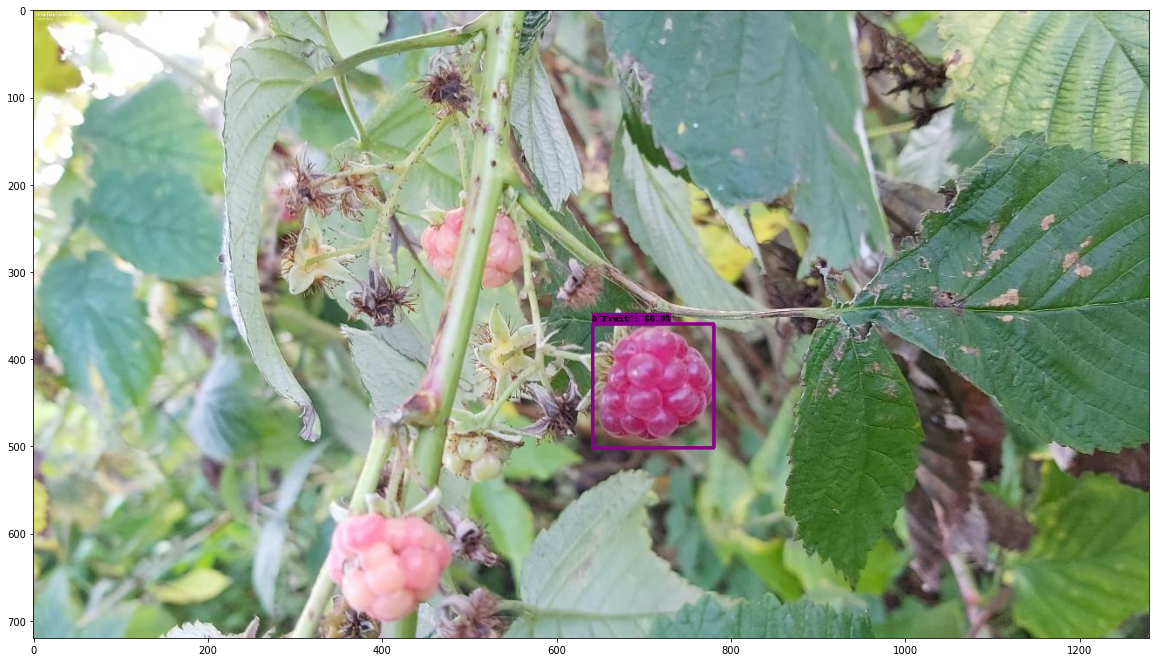

In [ ]:
# pic = 3456
# run_detector(filenames[pic])

In [ ]:
# execution_path = "C:/Users/M&M/Desktop/35-raspberry-01/"

# detection_py = ObjectDetection()
# detection_py.setModelTypeAsRetinaNet()
# detection_py.setModelPath(os.path.join(execution_path, 'resnet50_coco_best_v2.1.0.h5'))
# detection_py.loadModel()
# detections = detection_py.detectObjectsFromImage(input_image = os.join(execution_path, 'image.jpg'), output_image_path = os.join(execution_path, 'imagenew.jpg'))

# for eachObject in detections:
#   print(eachObject['name'],' : ', eachObject['percentage_probability'])